<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

from collections import Counter

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '..\Dataset\capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [35]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                              session_length=10, window_size=10):
    with open(site_freq_path, 'rb') as f:
        site_freq = pickle.load(f)
    
    sessions = []
    user_id = 1
    user_ids = []
    time_diff = []
    session_timespan = []
    num_of_unique_sites = []
    start_hour = []
    day_of_week = []
    i = 0 # session row initialization
    
    for file in tqdm_notebook(glob(path_to_csv_files + '/*.csv')):
        df = pd.read_csv(file, parse_dates=[0])
        timestamps = df.iloc[:, 0]
        sites = df.iloc[:, 1].tolist()

        sites_len = len(sites)
        i_normalized = 0 # session row in file initialization
        
        while i_normalized < sites_len:
            sessions.append([0] * session_length)
            user_ids.append(user_id)
            
            # Fill session_timespan list
            time_diff.append([0] * (session_length - 1))
            if i_normalized + session_length < sites_len:
                sess_timestamps = timestamps.iloc[i_normalized:(i_normalized + session_length)]
            else:
                sess_timestamps = timestamps.iloc[i_normalized:sites_len]
            sess_timespan = int((sess_timestamps.max() - sess_timestamps.min()) / np.timedelta64(1, 's'))
            session_timespan.append(sess_timespan)
            
            # Fill start_hour list
            start_hour.append(sess_timestamps.min().hour)
            
            # Fill day_of_week list
            day_of_week.append(sess_timestamps.min().dayofweek)
            
            for j in xrange(session_length):            
                # Fill sessions list
                cur_ind = i_normalized + j
                if cur_ind >= sites_len: break
                sessions[i][j] = site_freq[sites[cur_ind]][0]
                
                # Fill time_diff list
                if j > 8 or cur_ind > (sites_len - 2):
                    continue
                time_diff[i][j] = int((timestamps[cur_ind + 1] - timestamps[cur_ind]) / np.timedelta64(1, 's'))
                
            # Fill num_of_unique_sites list
            unique_sites = set(sessions[i])
            try: unique_sites.remove(0) # remove site '0' from session
            except: pass
            num_of_unique_sites.append(len(unique_sites))
                
            i += 1
            i_normalized += window_size
            
        user_id += 1
    
    # Convert sessions, features and user_ids to np.array
    X1 = np.array(sessions)
    X2 = np.array(time_diff)
    X3 = np.array(session_timespan).reshape(X1.shape[0], -1)
    X4 = np.array(num_of_unique_sites).reshape(X1.shape[0], -1)
    X5 = np.array(start_hour).reshape(X1.shape[0], -1)
    X6 = np.array(day_of_week).reshape(X1.shape[0], -1)
    y = np.array(user_ids).reshape(X1.shape[0], -1)
    
    sessions_arr = np.hstack( (X1, X2, X3, X4, X5, X6, y) )
    
    # Convert sessions list to dataframe
    sessions_df = pd.DataFrame(sessions_arr, columns=feature_names)
    
    return sessions_df

**Проверим функцию на игрушечном примере.**

In [36]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '3users'), 
                 site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_3users.pkl'),
                 feature_names=feature_names, session_length=10)

In [86]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,2,3,2,4,5,6,7,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,1,4,4,4,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,1,2,9,9,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,10,4,2,4,2,4,4,6,11,10,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,10,4,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [88]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'), 
                     site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                     feature_names=feature_names, session_length=10)


Wall time: 13.6 s


In [89]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,3,4,3,3,4,3,5,3,10,0,0,1,20,1,0,1,0,33,5,8,4,1
1,6,7,8,9,3,10,11,12,13,14,1,0,163,105,0,1,3,3,8,284,10,8,4,1
2,14,4,14,14,15,16,6,17,18,14,0,14,1,242,0,0,1,0,0,258,7,8,4,1
3,19,20,19,14,14,14,14,21,22,23,2,1,0,1,25,1,0,0,0,30,6,8,4,1
4,24,14,15,25,26,27,28,29,30,29,1,0,1,1,1,0,1,1,0,6,9,8,4,1


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'), 
                     site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                     feature_names=feature_names, session_length=10)


Wall time: 2min 11s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [24]:
new_features_10users = train_data_10users.loc[:, ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users.loc[:, ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [26]:
with open(os.path.join(PATH_TO_DATA, 'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [90]:
id_name_dict = {7: 'Mary-Kate', 3: 'Ashley', 8: 'Lindsey', 6: 'Naomi', 9: 'Avril',
               2: 'Bob', 4: 'Bill', 1: 'John', 5: 'Dick', 10: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [91]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

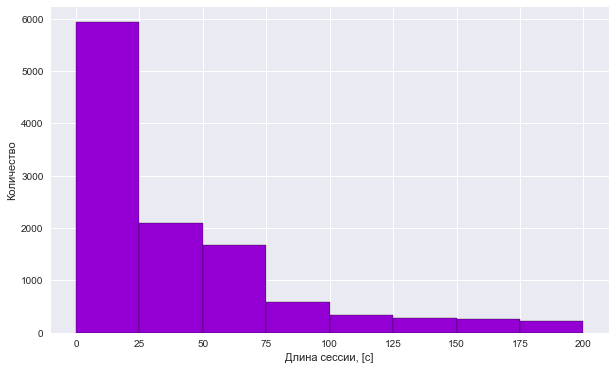

In [181]:
session_timespan_hist = train_data_10users[train_data_10users['session_timespan'] <= 200]['session_timespan']

plt.figure(figsize=(10, 6))
bins = range(session_timespan_hist.min(), int(np.ceil(session_timespan_hist.max())) + 1, 25)
plt.hist(session_timespan_hist, color='darkviolet', edgecolor='black', bins=bins, align='mid')
plt.xlabel(u'Длина сессии, [c]')
plt.ylabel(u'Количество');

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

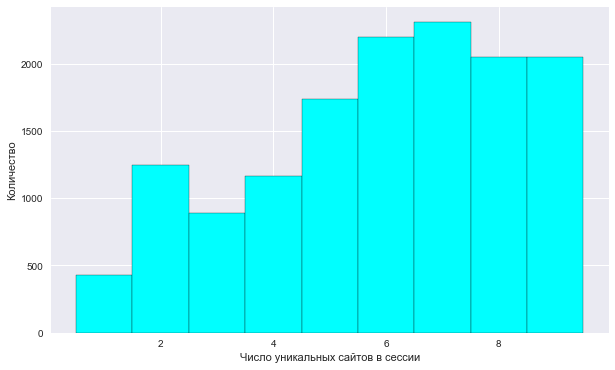

In [172]:
num_unique_sites_hist = train_data_10users['#unique_sites']

plt.figure(figsize=(10, 6))
bins = range(num_unique_sites_hist.min(), int(np.ceil(num_unique_sites_hist.max())) + 1)
plt.hist(num_unique_sites_hist, color='aqua', edgecolor='black', bins=bins, align='left')
plt.xlabel(u'Число уникальных сайтов в сессии')
plt.ylabel(u'Количество');

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

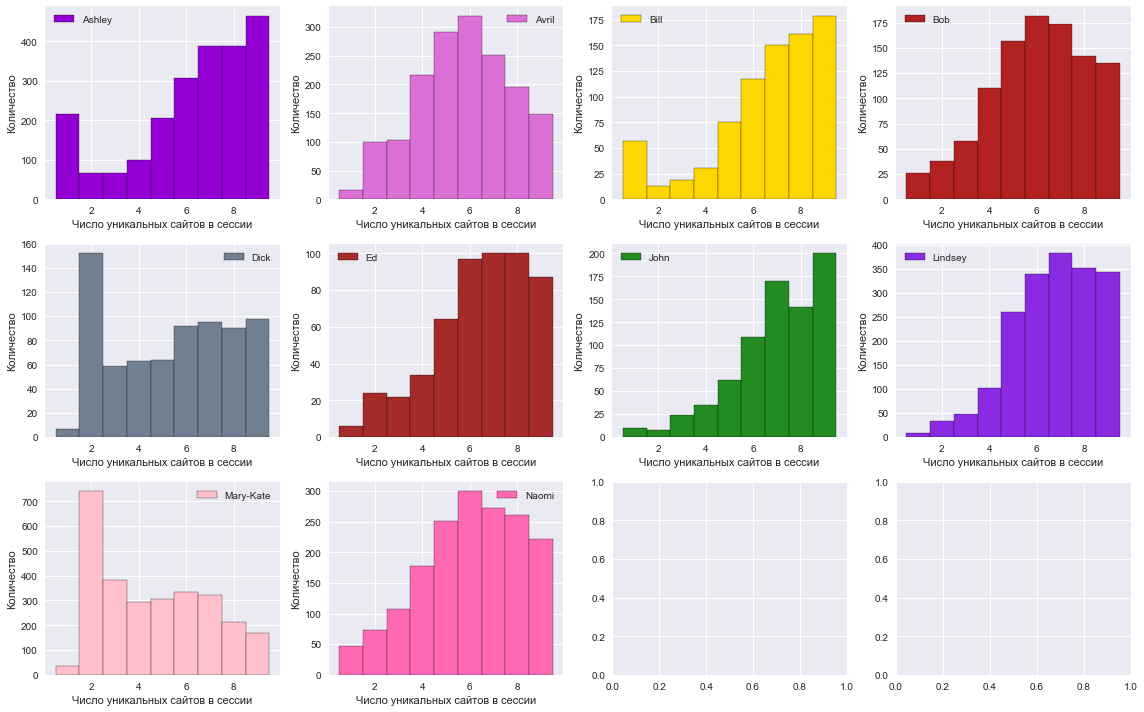

In [183]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in enumerate(train_data_10users.groupby('target')):
    i, j = idx // 4, idx % 4
    num_unique_sites_hist = sub_df['#unique_sites']
    bins = range(num_unique_sites_hist.min(), int(np.ceil(num_unique_sites_hist.max())) + 1)
    ax[i, j].hist(num_unique_sites_hist, label=user, color=color_dic[user], edgecolor='black', bins=bins, align='left')
    ax[i, j].legend()
    ax[i, j].set_xlabel(u'Число уникальных сайтов в сессии')
    ax[i, j].set_ylabel(u'Количество')
    plt.tight_layout()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

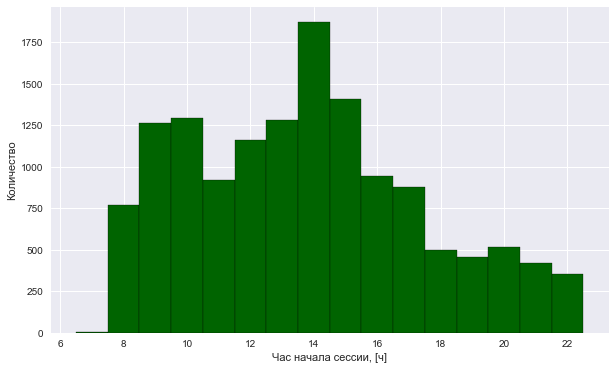

In [170]:
start_hour_hist = train_data_10users['start_hour']

plt.figure(figsize=(10, 6))
bins = range(start_hour_hist.min(), int(np.ceil(start_hour_hist.max())) + 1)
plt.hist(start_hour_hist, color='darkgreen', edgecolor='black', bins=bins, align='left')
plt.xlabel(u'Час начала сессии, [ч]')
plt.ylabel(u'Количество');

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

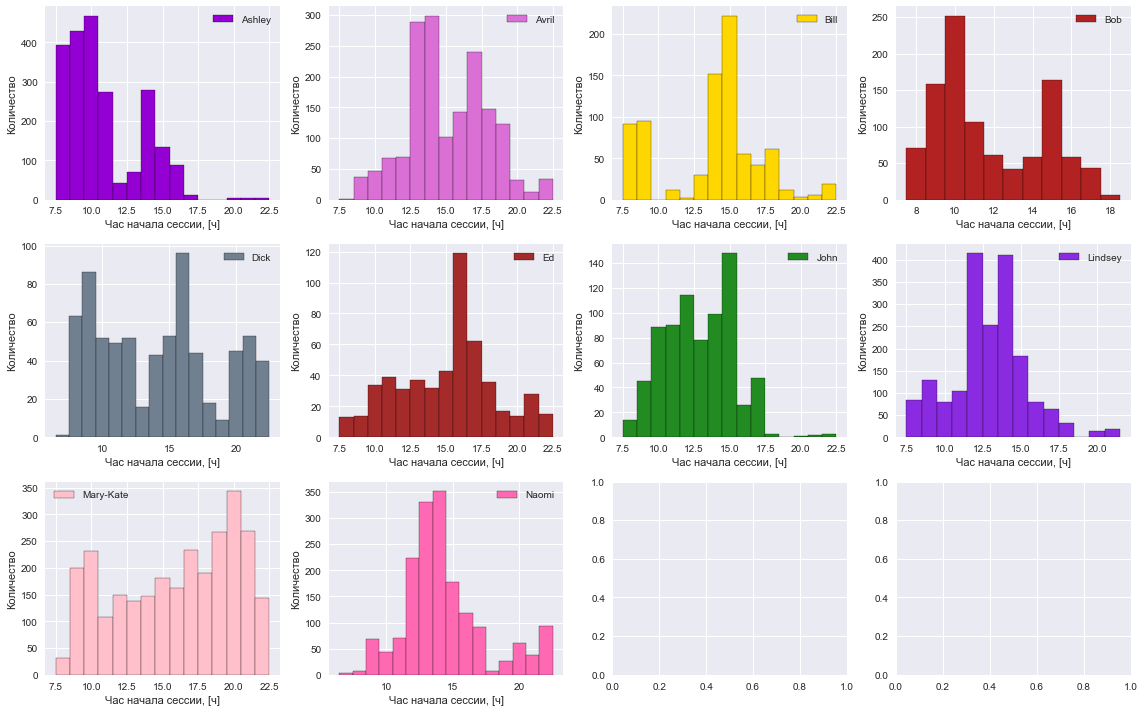

In [182]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in enumerate(train_data_10users.groupby('target')):
    i, j = idx // 4, idx % 4
    start_hour_hist = sub_df['start_hour']
    bins = range(start_hour_hist.min(), int(np.ceil(start_hour_hist.max())) + 1)
    ax[i, j].hist(start_hour_hist, label=user, color=color_dic[user], edgecolor='black', bins=bins, align='left')
    ax[i, j].legend()
    ax[i, j].set_xlabel(u'Час начала сессии, [ч]')
    ax[i, j].set_ylabel(u'Количество')
    plt.tight_layout()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

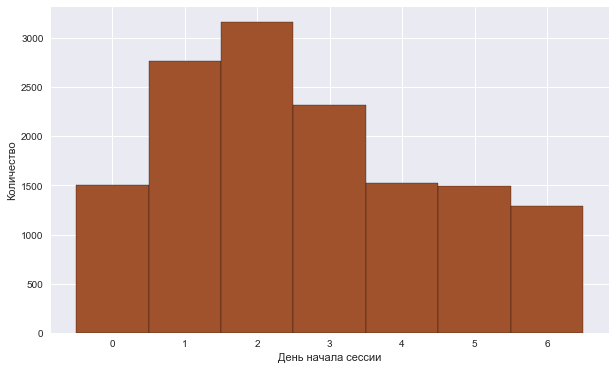

In [151]:
day_of_week_hist = train_data_10users['day_of_week']

plt.figure(figsize=(10, 6))
plt.hist(day_of_week_hist, color='sienna', edgecolor='black', bins=range(0,8), align='left')
plt.xlabel(u'День начала сессии')
plt.ylabel(u'Количество');

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

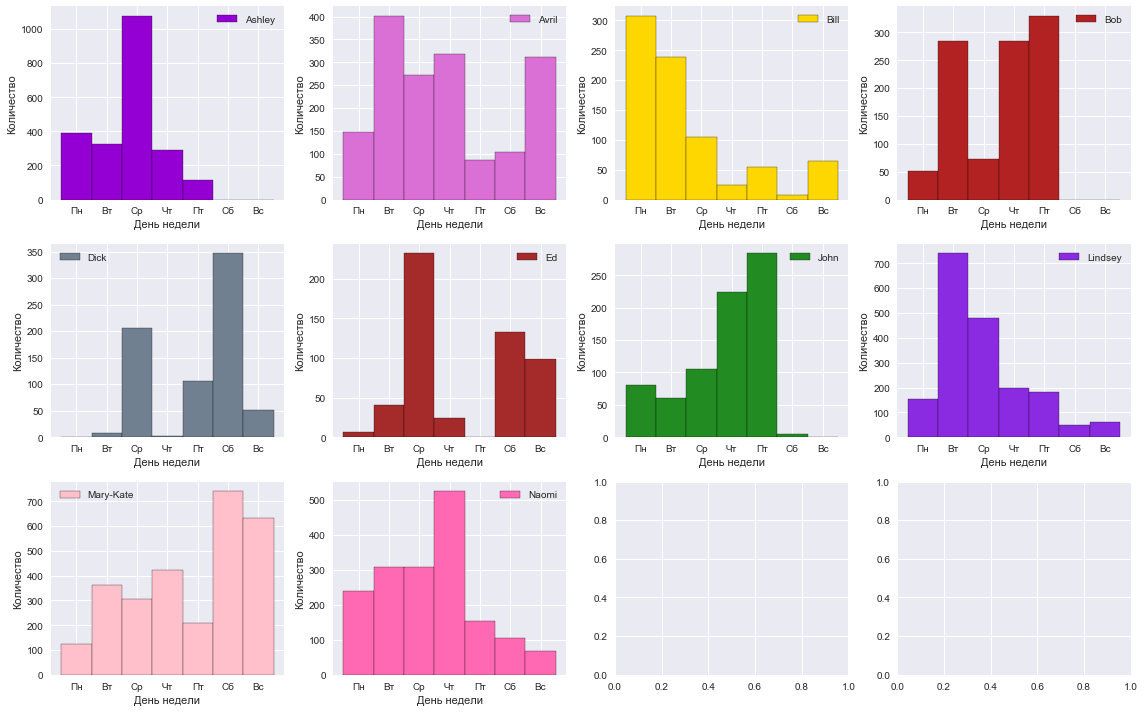

In [194]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in enumerate(train_data_10users.groupby('target')):
    i, j = idx // 4, idx % 4
    day_of_week_hist = sub_df['day_of_week']
    bins = range(0, 8)
    ax[i, j].hist(day_of_week_hist, label=user, color=color_dic[user], edgecolor='black', bins=bins, align='left')
    ax[i, j].legend()
    ax[i, j].set_xlabel(u'День недели')
    ax[i, j].set_ylabel(u'Количество')
    plt.tight_layout()
    ax[i, j].set_xticks(range(0, 7))
    ax[i, j].set_xticklabels([u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс'])

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

**Ashley**: посещает в среднем около 8-9 уникальных сайтов за сессию; обычно сёрфит утром и в обед; только в будние дни (в среду пик активности)

**Avril**: посещает в среднем около 6 уникальных сайтов за сессию; обычно сёрфит в обед и сразу после работы; пик активности середина рабочей недели и вс

**Bill**: посещает в среднем около 8-9 уникальных сайтов за сессию; обычно сёрфит утром и в обед; пик активности приходится на начало рабочей недели

**Bob**: посещает в среднем около 6-7 уникальных сайтов за сессию; обычно сёрфит утром и в обед; только в будние дни

**Dick**: равномерное распределение, кроме пн и вт; обычно сёрфит утром, днём и вечером; выходные и середина недели

**Ed**: посещает в среднем около 7-8 уникальных сайтов за сессию; равномерно, пик после обеда; выходные и середина недели

**John**: посещает в среднем около 6-7 уникальных сайтов за сессию; в течение рабочего дня; в основном будние дни с увеличением к пятнице

**Lindsey**: посещает в среднем около 7-8 уникальных сайтов за сессию; в течении рабочего дня с пиком в обед; пик в вт-ср

**Mary-Kate**: равномерное распределение, кроме пн и вт; равномерно; чаще в выходные

**Naomi**: посещает в среднем около 6-7 уникальных сайтов за сессию; в обед и поздний вечер; чаще в рабочие дни

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [195]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as f:
    site_freq_10 = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [222]:
site_freq_10_sorted = sorted(site_freq_10.items(), key=lambda x: x[1][1], reverse=True)

top10_freqs = [x[1][1] for x in site_freq_10_sorted[:10]]
top10_sites = [x[0] for x in site_freq_10_sorted[:10]]

print('Freq Site')
for freq, site in zip(top10_freqs, top10_sites):
    print(freq, site)

Freq Site
8300 s.youtube.com
7813 www.google.fr
5441 www.google.com
4158 mail.google.com
4141 www.facebook.com
3758 apis.google.com
3244 r3---sn-gxo5uxg-jqbe.googlevideo.com
3094 r1---sn-gxo5uxg-jqbe.googlevideo.com
2630 plus.google.com
2089 accounts.google.com


**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

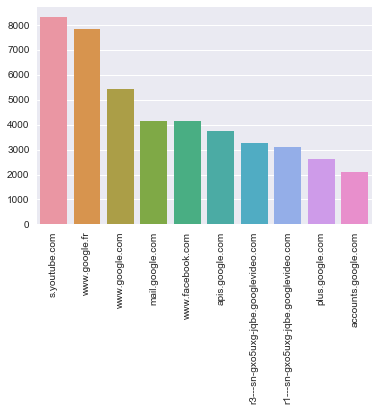

In [236]:
ax = sns.barplot(top10_sites, top10_freqs)
ax.set_xticklabels(top10_sites, rotation=90);

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [237]:
train_data_10users['session_timespan'].median()

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [238]:
train_data_10users['day_of_week'].median()

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [239]:
train_data_10users['start_hour'].median()

14.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [240]:
train_data_10users['#unique_sites'].median()

6.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [ ]:
def feature_engineering(path_to_csv_files, features, session_length=10):
    '''
    ВАШ КОД ЗДЕСЬ
    ''' 

In [ ]:
new_features_10users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
new_features_150users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 